In [2]:
library(dplyr)
library(ggplot2)
library(Biostrings)
library(tidyr)
library(ggbeeswarm)
library(RColorBrewer)
library(ggpubr)
library(stringr)

In [3]:
theme_set(theme_classic() + 
          theme(axis.title.x = element_text(
                    size = rel(1)),
                axis.title.y = element_text(size = rel(1))
                , legend.position = "none",
                strip.background = element_blank(), strip.placement = "outside"
              ,strip.text.x = element_text(vjust = 2, size = rel(8/6))
              , axis.ticks.y = element_line(color = "black") 
                , axis.ticks.x = element_blank(), panel.spacing.x = unit(0, "null")
               ,plot.title = element_text(size = rel(1))
         ,axis.text.x = element_text(colour = "black", size = 8)
          ,axis.text.y = element_text(colour = "black", size = 8)
               ,text = element_text(family="ArialMT", size = 8)
          ,plot.margin = margin(0, 0, 0, 0, "in"),
              plot.background = element_rect(fill='transparent', color=NA),
              panel.background = element_rect(fill='transparent', color=NA),
              rect = element_rect(fill = "transparent")
         ))

In [4]:
crispresso_data <- read.delim("data/CRISPResso_summary.txt")
crispresso_data$Sample <- gsub("REP\\d_", "", crispresso_data$Batch)
crispresso_data$Locus <- gsub("_.*", "", crispresso_data$Sample)
crispresso_data$gDNA_insert <- gsub(".*_", "", gsub("_peg.*", "", crispresso_data$Batch))
crispresso_data <- crispresso_data %>% group_by(Sample) %>% mutate(Correct_edit_mean = mean(Correct_edit),
                                                                     Indels_mean = mean(Indels),
                                                                      Correct_edit_sd = sd(Correct_edit),
                                                                     Indels_sd = sd(Indels))

In [5]:
dist_cutoff <- 5
insert_set_list <- list()
for (locus in c("RNF2", "HEK3", "EMX1")) {
    crispresso_data_plot <- crispresso_data[grepl(locus, crispresso_data$Batch),]
    crispresso_data_plot <- crispresso_data_plot[!duplicated(crispresso_data_plot$Sample),]
    crispresso_data_dist <- data.frame(matrix(nrow = nrow(crispresso_data_plot)
                                                   , ncol = nrow(crispresso_data_plot)))
    rownames(crispresso_data_dist) <- crispresso_data_plot$gDNA_insert
    colnames(crispresso_data_dist) <- crispresso_data_plot$gDNA_insert
    for (i in 1:nrow(crispresso_data_plot)) {
        for (j in 1:nrow(crispresso_data_plot)){
            crispresso_data_dist[i,j] <- abs(crispresso_data_plot$Correct_edit_mean[i] - 
                                             crispresso_data_plot$Correct_edit_mean[j])
        }
    }

    insert_sets <- data.frame(matrix(nrow = nrow(crispresso_data_plot)
                                                   , ncol = 7))
    colnames(insert_sets) <- c("locus","seed","set_size", "set","mean_efficiency", "min_efficiency"
                                    , "max_efficiency")
    for (i in 1:ncol(crispresso_data_dist)) {
        insert_sets[i,1] <- locus
        insert_sets[i,2] <- colnames(crispresso_data_dist)[i]
        barcode_set <- sort(rownames(crispresso_data_dist)[crispresso_data_dist[,i] < dist_cutoff])
        insert_sets[i,3] <- length(barcode_set)
        insert_sets[i,4] <- paste(barcode_set, collapse = ";")
        insert_sets[i,5] <- mean(crispresso_data_plot$Correct_edit_mean[crispresso_data_plot$gDNA_insert %in%
                                                                            barcode_set])
        insert_sets[i,6] <- min(crispresso_data_plot$Correct_edit_mean[crispresso_data_plot$gDNA_insert %in%
                                                                            barcode_set])
        insert_sets[i,7] <- max(crispresso_data_plot$Correct_edit_mean[crispresso_data_plot$gDNA_insert %in%
                                                                            barcode_set])
    }
    insert_sets$max_diff <- insert_sets$max_efficiency - insert_sets$min_efficiency
    insert_sets <- insert_sets[order(insert_sets$max_diff),]
    insert_sets <- insert_sets[order(insert_sets$set_size, decreasing = TRUE),]
    insert_set_list[[locus]] <- unlist(str_split(insert_sets$set[order(insert_sets$set_size, decreasing = TRUE)][1]
                                                 , ";"))
}

In [6]:
insertion_set <- rbind(data.frame(locus = "EMX1_10percent", gDNA_insert = insert_set_list[["EMX1"]])
                        , data.frame(locus = "HEK3_10percent", gDNA_insert = insert_set_list[["HEK3"]])
                        , data.frame(locus = "RNF2_10percent", gDNA_insert = insert_set_list[["RNF2"]]))

In [51]:
write.table(insertion_set, "data/insertion_sets_gDNA_frame.txt", quote = FALSE, sep = '\t', row.names = TRUE)

In [7]:
MFBC_order <- read.delim("data/MERFISH_BC_order.txt")

In [8]:
all_insert <- crispresso_data[,c('Locus', 'gDNA_insert')]
all_insert <- all_insert[!duplicated(all_insert),]
all_insert$within_10_percent <- ifelse(all_insert$Locus == "EMX1"
                                       , all_insert$gDNA_insert %in% insertion_set$gDNA_insert[
                                           insertion_set$locus == "EMX1_10percent"],
                                       ifelse(all_insert$Locus == "HEK3"
                                              , all_insert$gDNA_insert %in% insertion_set$gDNA_insert[
                                           insertion_set$locus == "HEK3_10percent"],
                                              ifelse(all_insert$Locus == "RNF2"
                                              , all_insert$gDNA_insert %in% insertion_set$gDNA_insert[
                                           insertion_set$locus == "RNF2_10percent"]
                                                     , NA)))
all_insert$final_20 <- ifelse(all_insert$Locus == "EMX1"
                                       , all_insert$gDNA_insert %in% unique(MFBC_order$insertion[
                                           MFBC_order$site == "EMX1"]),
                                       ifelse(all_insert$Locus == "HEK3"
                                              , all_insert$gDNA_insert %in% unique(MFBC_order$insertion[
                                           MFBC_order$site == "HEK3"]),
                                              ifelse(all_insert$Locus == "RNF2"
                                              , all_insert$gDNA_insert %in% unique(MFBC_order$insertion[
                                           MFBC_order$site == "RNF2"]), NA)))
write.table(all_insert, file = "data/top96_insertion_key.txt", sep = "\t", quote = FALSE, row.names = FALSE)

In [9]:
plot_top96 <- function(locus) {
    crispresso_data_plot <- crispresso_data[crispresso_data$Locus == locus,]
    crispresso_data_plot$gDNA_insert <- factor(crispresso_data_plot$gDNA_insert
                                               , levels = unique(crispresso_data_plot$gDNA_insert[
                                                   order(crispresso_data_plot$Correct_edit_mean, decreasing = TRUE)]))
    crispresso_data_plot <- crispresso_data_plot[order(crispresso_data_plot$gDNA_insert),]
    crispresso_data_plot$set <- crispresso_data_plot$gDNA_insert %in% insertion_set$gDNA_insert[
         insertion_set$locus == paste0(locus, "_10percent")]
    ggplot(crispresso_data_plot,  aes(x = gDNA_insert,y = Correct_edit, fill = set)) + 
            geom_bar(stat = "summary", fun = "mean",position = position_dodge(width = 0.9)
            , color = "black", size=0.25, width = 0.8) + 
        scale_fill_manual(values = c("lightgrey", "darkgrey")) +
            stat_summary(fun.data = "mean_sdl", fun.args = list(mult = 1)
                         , geom = "errorbar"
                , position = position_dodge(width = 0.9), width = 0.4, linewidth = 0.25) + 
            geom_point(size = 0.5, position = position_dodge(width = 0.1)) + 
            ylab("Total sequencing reads with\nspecified edit (%)") + xlab("Insertion sequence") +
            ggtitle(paste0(locus, " top ", length(unique(crispresso_data_plot$gDNA_insert))," insertions")) +
            scale_y_continuous(breaks=seq(0,80,by = 10), limits=c(0, 80), expand = c(0, 0)) + 
            theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1
                                             , color = ifelse(unique(crispresso_data_plot$gDNA_insert) %in% 
                                                              MFBC_order$insertion[MFBC_order$site == locus]
                                                              , "red", "black")))
}

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”
Warning message:
“Vectorized input to `element_text()` is not officially supported.
ℹ Results may be unexpected or may change in future versions of ggplot2.”


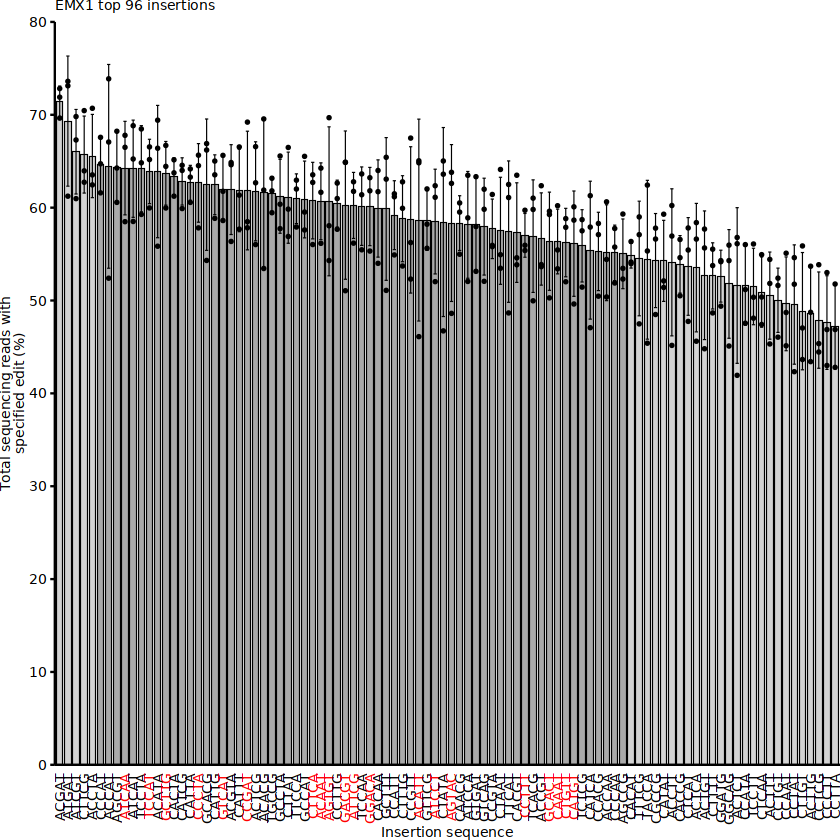

In [10]:
locus  <- "EMX1"
pdf('plots/EMX1_top96.pdf', width = 8.3, height = 2, useDingbats = FALSE)
plot_top96(locus)
dev.off()

Warning message:
“Vectorized input to `element_text()` is not officially supported.
ℹ Results may be unexpected or may change in future versions of ggplot2.”


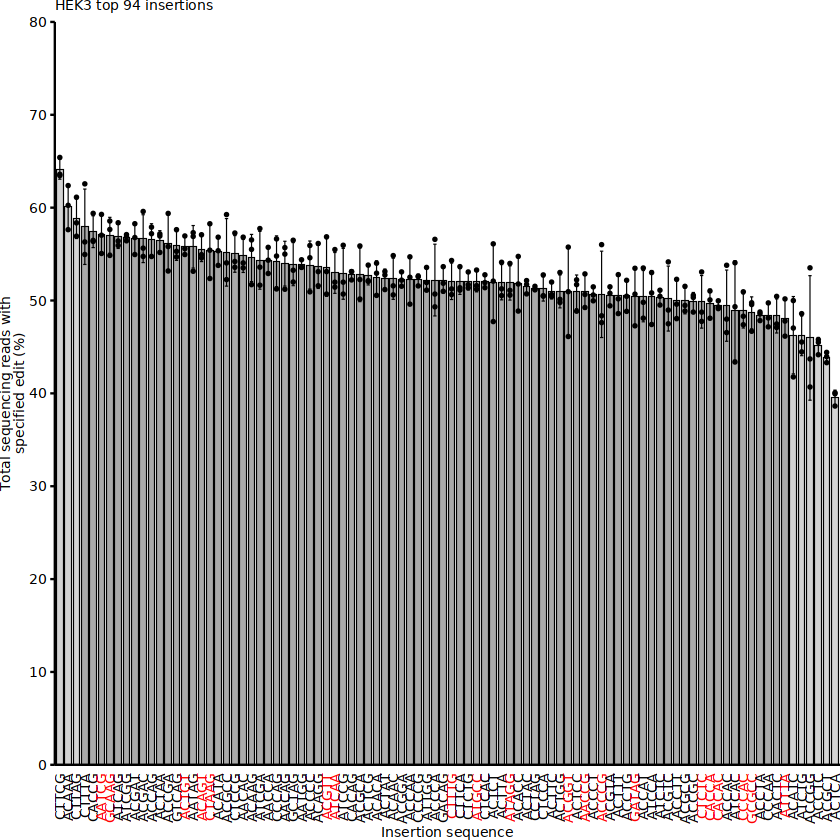

In [11]:
locus  <- "HEK3"
pdf('plots/HEK3_top96.pdf', width = 8.3, height = 2, useDingbats = FALSE)
plot_top96(locus)
dev.off()

Warning message:
“Vectorized input to `element_text()` is not officially supported.
ℹ Results may be unexpected or may change in future versions of ggplot2.”


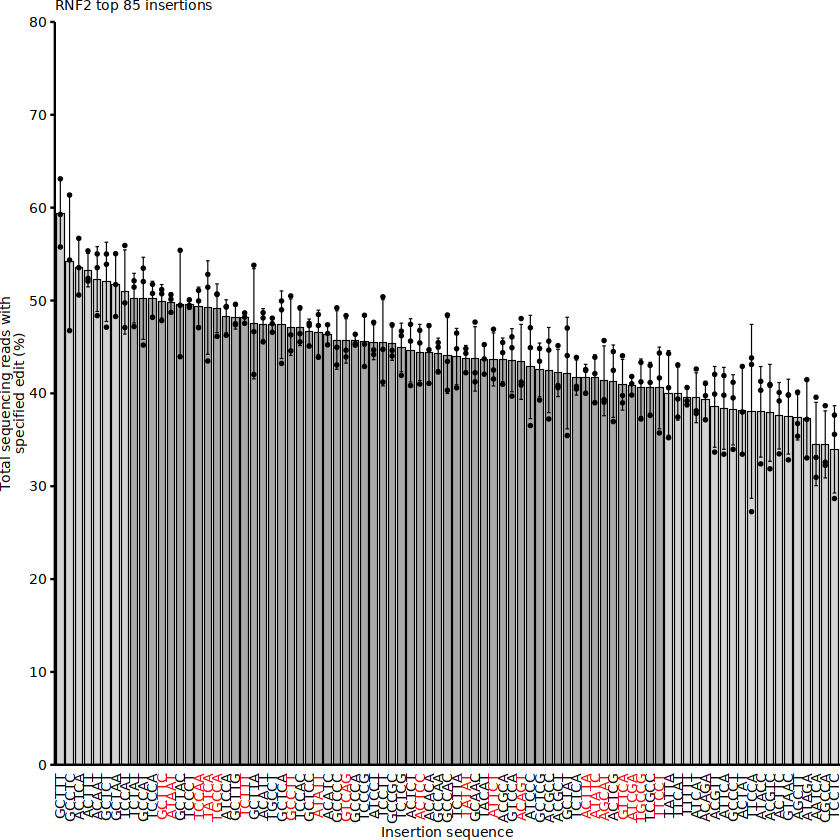

In [12]:
locus  <- "RNF2"
pdf('plots/RNF2_top96.pdf', width = 8.3, height = 2, useDingbats = FALSE)
plot_top96(locus)
dev.off()